# <center> Face mask detection model trainer </center>

## Mount your Google drive folder on Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Setting the working directory
import os
os.chdir(r"/content/gdrive/My Drive/Face_Mask_Detection/")

In [4]:
%%writefile requirements.txt
tensorflow==2.1 # TensorFlow is an open source machine learning framework for everyone.
numpy==1.18.2 # NumPy is the fundamental package for array computing with Python.
argparse==1.1 # Python command-line parsing library
opencv-python==4.2.0.34 # Wrapper package for OpenCV python bindings.
imutils==0.5.3 # A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, detecting edges, and much more easier with OpenCV and both Python 2.7 and Python 3.
scikit-learn==0.23.1 # A set of python modules for machine learning and data mining
matplotlib==3.2.1 # Python plotting package

Overwriting requirements.txt


## Install requirements

In [5]:
!pip install -r "./requirements.txt"

     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 20.2MB 53kB/s 
     |████████████████████████████████| 153kB 42.6MB/s 
     |████████████████████████████████| 28.2MB 1.6MB/s 
     |████████████████████████████████| 6.9MB 28.6MB/s 
     |████████████████████████████████| 12.4MB 124kB/s 
     |████████████████████████████████| 450kB 41.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 3.9MB 34.8MB/s 
  Created wheel for argparse: filename=argparse-1.1-cp36-none-any.whl size=20735 sha256=b4009d1001cbfbec40219022a066d91100c45a2581ea2b2dc3090410b5ce0243
  Stored in directory: /root/.cache/pip/wheels/eb/d9/dc/c82fc53ba45624213f73beb92add224b9bd8a30581c2d2a7b5
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b59466aecc9a69e90fc8d51c5067d9eb804d3aee81140f83add46ae7880b48cf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699fe

In [1]:
# Setting the working directory
import os
os.chdir(r"/content/gdrive/My Drive/Face_Mask_Detection/")

## Import the necessary packages

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## Configuration

In [3]:
# File Location
data_path="./dataset/"
model_path="./model"
# Model hyperparameter
INIT_LR = 1e-4 # Initial learning rate
EPOCHS = 20  # Number of epoch
BS = 32 # Batch size 

## Data preparation

In [19]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(data_path))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [20]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, validX, trainY, validY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [21]:
print(f"Train and validation data size are {trainX.shape[0]} and {validX.shape[0]}")

Train and validation data size are 3076 and 770


In [22]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Model preparation

In [23]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [24]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validX, validY),
	validation_steps=len(validX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(validX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
Train for 96 steps, validate on 770 samples
Epoch 1/20
96/96 [==============================] - 44s 454ms/step - loss: 0.5139 - accuracy: 0.7428 - val_loss: 0.5384 - val_accuracy: 0.7044
Epoch 2/20
96/96 [==============================] - 40s 415ms/step - loss: 0.3054 - accuracy: 0.8860 - val_loss: 0.4344 - val_accuracy: 0.8125
Epoch 3/20
96/96 [==============================] - 39s 408ms/step - loss: 0.2209 - accuracy: 0.9169 - val_loss: 0.4156 - val_accuracy: 0.8268
Epoch 4/20
96/96 [==============================] - 39s 406ms/step - loss: 0.1895 - accuracy: 0.9300 - val_loss: 0.3044 - val_accuracy: 0.8828
Epoch 5/20
96/96 [==============================] - 39s 405ms/step - loss: 0.1705 - accuracy: 0.9399 - val_loss: 0.3942 - val_accuracy: 0.8490
Epoch 6/20
96/96 [==============================] - 39s 403ms/step - loss: 0.1445 - accuracy: 0.9524 - val_loss: 0.3143 - val_accuracy: 0.8815
Epoch 7/20
96/96 [=====

## Results

              precision    recall  f1-score   support

   with_mask       0.99      0.80      0.89       384
without_mask       0.83      0.99      0.91       386

    accuracy                           0.90       770
   macro avg       0.91      0.90      0.90       770
weighted avg       0.91      0.90      0.90       770

[INFO] saving mask detector model...


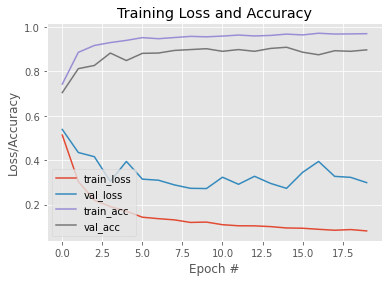

In [25]:
# show a nicely formatted classification report
print(classification_report(validY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(model_path, save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

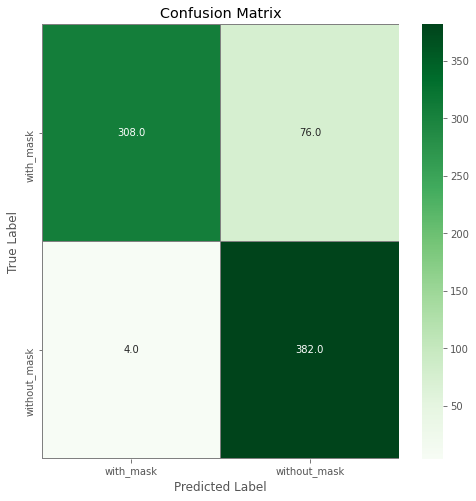

In [39]:
# Confusion matrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(validY.argmax(axis=1), predIdxs) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(list(lb.classes_)); ax.yaxis.set_ticklabels(list(lb.classes_));
plt.show()